In [1]:
import sys, os, pickle
sys.path.append('/home/om2382/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import *
from learning_algorithms import *
from optimizers import *
from plotting import *
from torch_tools import *
from wrappers import *
import matplotlib.pyplot as plt
import torch
from torch.optim.lr_scheduler import ExponentialLR

In [2]:
T_trial = 100
task = Context_Dependent_Decision_Task(T_trial=T_trial, input_var=0.1, report_cue=True)

In [3]:
root_name = 'BPTT_CDM_b200_50_examples_ctx0'
signal_dicts, result = unpack_cross_compare_result(root_name, checkpoint_stats={'test_loss': get_checkpoint_loss,
                                                                                'n_nodes': get_checkpoint_n_stable_FPs,
                                                                                'discriminant': get_checkpoint_cubic_discriminant,
                                                                                'lengths': get_checkpoint_maximum_cluster_distances},
                                                   results_subdir='PNAS_Paper',
                                                   multi_job_comp=True)

In [ ]:
root_name = 'BPTT_examples_ctx0'
results_dir = '/home/om2382/learning-dynamics/results/misc'
analysis_jobs = [j for j in os.listdir(results_dir) if root_name in j and 'analyze' in j]
checkpoints_dicts = {}
for job_name in analysis_jobs:
    indices, checkpoints = unpack_analysis_results(os.path.join(results_dir, job_name))
    checkpoints_dicts[job_name] = {'indices': indices,
                                   'checkpoints': checkpoints}

(-9.950000000000001, 208.95, -3.0, -2.0)

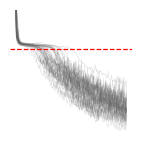

In [7]:
### --- STACK LOSS CURVES --- ###
from scipy.stats import spearmanr
loss_events, line_attractor_events, node_events = detect_events(signal_dicts,
                                                                test_loss_threshold=-2.32,
                                                                length_threshold=-11)
cm = 1/2.54
fig = plt.figure(figsize=(4*cm, 4*cm))
for i_key, key in enumerate(signal_dicts):
    plt.plot(np.log10(signal_dicts[key]['test_loss']), color='#646464', linewidth=0.4, alpha=0.2)
plt.axhline(y=-2.32, color='r', linestyle='--', linewidth=0.9)
plt.ylim([-3, -2])
plt.axis('off')
#fig.savefig('figs/stacked_loss.pdf', format='pdf')

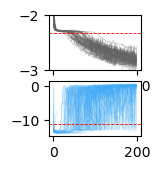

In [7]:
### --- PLOT MANY LOSS CURVES --- ###
cm = 1/2.54
fig, ax = plt.subplots(2, 1, figsize=(3*cm, 4*cm))
for i_key, key in enumerate(signal_dicts):
    l = np.log10(signal_dicts[key]['test_loss'])
    #plt.plot(moving_average_filter(l, window_size=20), color='#646464', linewidth=0.4)
    ax[0].plot(l, color='#646464', linewidth=0.4, alpha=0.4)
    ax[1].plot(signal_dicts[key]['lengths'], linewidth=0.3, color='#3FA9F5', alpha=0.3)
ax[0].axhline(y=-2.32, color='r', linestyle='--', linewidth=0.6)
ax[1].axhline(y=-11, color='r', linestyle='--', linewidth=0.6)
ax[0].set_ylim([-3, -2])
#ax[0].axis('off')
#ax[1].axis('off')
fig.savefig('figs/loss_length_all_BPTT_CDM.pdf', format='pdf')

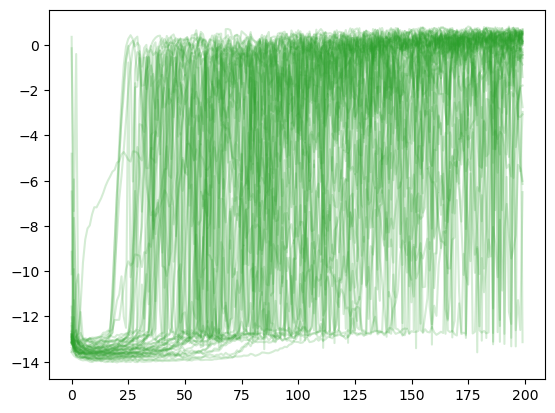

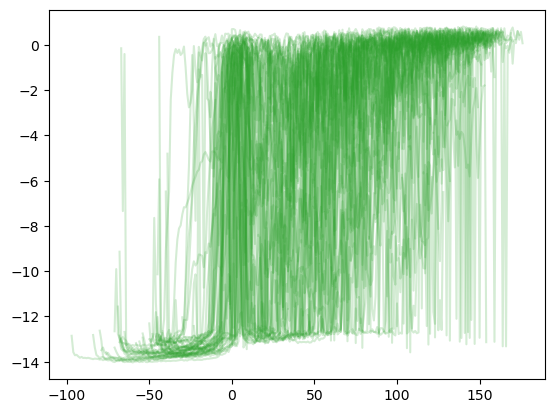

In [8]:
### --- PLOT ALIGNED TRACES --- ###
plt.figure()
for i_key, key in enumerate(signal_dicts):
    t_shift = loss_events[i_key]
    plt.plot(list(range(0, 200)), signal_dicts[key]['lengths'], color='C2', alpha=0.2)
plt.figure()
for i_key, key in enumerate(signal_dicts):
    t_shift = loss_events[i_key]
    plt.plot(list(range(-t_shift, 200 - t_shift)), signal_dicts[key]['lengths'], color='C2', alpha=0.2)

SpearmanrResult(correlation=0.8417357974706916, pvalue=1.9099267618662447e-14)


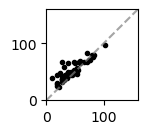

In [17]:
### --- PLOT EVENTS --- ###
from scipy.stats import spearmanr
loss_events, line_attractor_events, node_events = detect_events(signal_dicts,
                                                                test_loss_threshold=-2.32,
                                                                length_threshold=-11,
                                                                ignore_first=10)
cm = 1/2.54
fig = plt.figure(figsize=(3*cm, 3*cm))
x = np.arange(0, 200, 1)
plt.plot(line_attractor_events, loss_events, '.', color='k')
plt.plot(x, x, 'C7', linestyle='--', alpha=0.7)
plt.xlim([0, 160])
plt.ylim([0, 160])
#plt.xticks([20, 60], [200, 600])
#plt.yticks([])
#ccoef = np.corrcoef(loss_events, line_attractor_events)[0,1]
ccoef = spearmanr(loss_events, line_attractor_events)
#plt.title(f'r = {ccoef:.2f}')
print(ccoef)
fig.savefig('figs/CDDM_loss_line.pdf', format='pdf')
#plt.axis('off')

([], [])

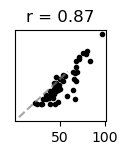

In [7]:
### --- PLOT EVENTS --- ###
cm = 1/2.54
fig = plt.figure(figsize=(3*cm, 3*cm))
x = np.arange(5, 60, 1)
plt.plot(loss_events, line_attractor_events, '.', color='k')
plt.plot(x, x, 'C7', linestyle='--', alpha=0.7)
#plt.xticks([20, 60], [200, 600])
ccoef = np.corrcoef(loss_events, line_attractor_events)[0,1]
plt.title(f'r = {ccoef:.2f}')
plt.yticks([])
#fig.savefig('figs/loss_line.pdf', format='pdf')
#plt.axis('off')

#cm = 1/2.54
#fig = plt.figure(figsize=(3*cm, 3*cm))
#x = np.arange(5, 60, 1)
#plt.plot(node_events, line_attractor_events, '.', color='k')
#plt.plot(x, x, 'C7', linestyle='--', alpha=0.7)
#plt.xticks([20, 60], [200, 600])
#plt.yticks([])
#fig.savefig('figs/node_line.pdf', format='pdf')

#plt.figure()
#plt.plot(loss_events, node_events, '.')
#plt.plot(x, x, 'r')

#plt.figure()
#plt.plot(node_events, line_attractor_events, '.')
#plt.plot(x, x, 'r')

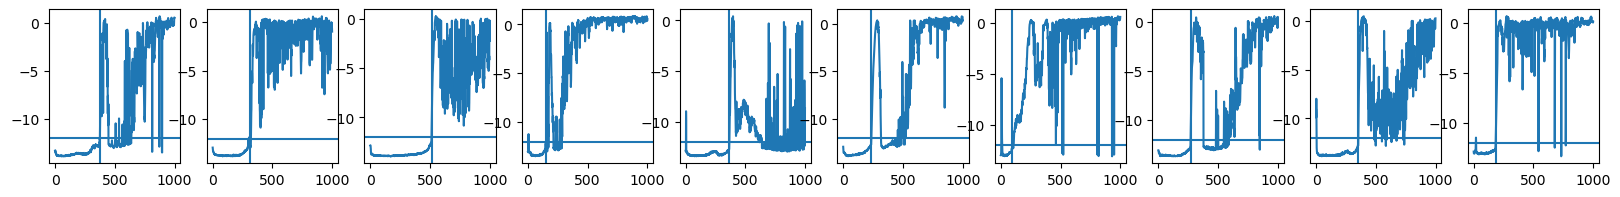

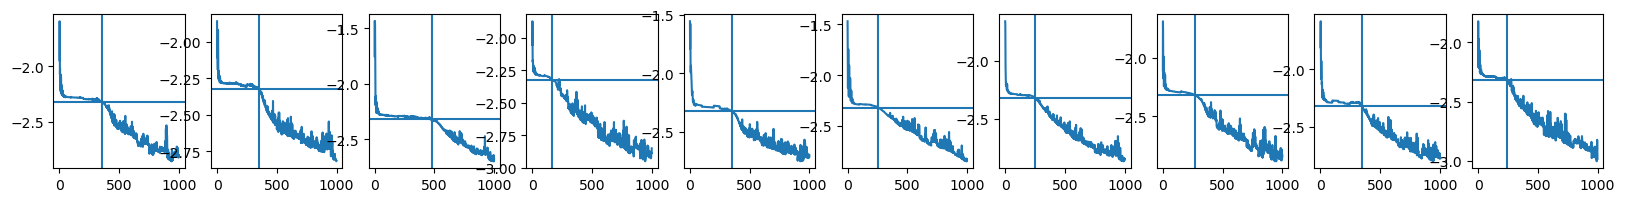

In [15]:
### --- VALIDATE THRESHOLD VISUALLY --- ###

fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i_key, key in enumerate(signal_dicts):
    ax[i_key].plot(signal_dicts[key]['lengths'])
    ax[i_key].axhline(y=-12)
    ax[i_key].axvline(x=line_attractor_events[i_key])
    
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i_key, key in enumerate(signal_dicts):
    ax[i_key].plot(np.log10(signal_dicts[key]['test_loss']))
    ax[i_key].axhline(y=test_loss_threshold)
    ax[i_key].axvline(x=loss_events[i_key])